In [11]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import cross_validate, StratifiedKFold

from sklearn.preprocessing import StandardScaler

In [8]:
Data = pd.read_csv("./Result&Weather_data.csv")
Data.Fire_Count = (Data.Fire_Count>0).astype(int)
Data.head()

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio,human_adj_area,...,ctr_mean,ctr_std,n_ctrs,Fire_Count,기온(°C)_mean,기온(°C)_std,풍속(m/s)_mean,풍속(m/s)_std,실효습도_mean,실효습도_std
0,11110101,23,4,0.125,0.6,792617.902967,POLYGON ((953700.0221347539 1954605.0654306228...,67529.485826,0.085198,36117.996122,...,173.809524,73.940935,21,0,12.15567,10.741712,1.245053,0.829653,33.010423,10.35339
1,11110102,23,4,0.125,0.6,98821.715201,POLYGON ((953233.4654317541 1953996.9839332262...,59869.101208,0.605829,40495.878201,...,87.500000,32.274861,4,0,12.15567,10.741712,1.245053,0.829653,33.010423,10.35339
2,11110103,23,4,0.125,0.6,73271.654659,POLYGON ((953560.2281430522 1954257.4664824517...,776.906691,0.010603,0.000000,...,50.000000,0.000000,1,0,12.15567,10.741712,1.245053,0.829653,33.010423,10.35339
3,11110109,23,4,0.125,0.6,258561.672009,POLYGON ((952981.2076348594 1953604.3112467206...,79017.474842,0.305604,77079.210797,...,160.000000,71.879529,10,0,12.15567,10.741712,1.245053,0.829653,33.010423,10.35339
4,11110111,23,4,0.125,0.6,417438.349374,"POLYGON ((952769.057857475 1954155.9539321065,...",113433.905865,0.271738,113433.905865,...,187.500000,84.210131,14,0,12.15567,10.741712,1.245053,0.829653,33.010423,10.35339


In [9]:
Data.columns

Index(['EMD_CD', 'DMCLS_CD_wmode', 'AGCLS_CD_wmode', 'frtp_avg', 'dnst_avg',
       'Area', 'geometry', 'mtn_area', 'Mtn_Ratio', 'human_adj_area',
       'human_mtn_Ratio', 'human_Total_Ratio', 'ctr_mean', 'ctr_std', 'n_ctrs',
       'Fire_Count', '기온(°C)_mean', '기온(°C)_std', '풍속(m/s)_mean',
       '풍속(m/s)_std', '실효습도_mean', '실효습도_std'],
      dtype='object')

In [21]:
svm_model = SVC(C= 1, kernel = "rbf", class_weight='balanced', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth = 3, scale_pos_weight=3, random_state=42)

stacking = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5,  # internal cross-validation to generate meta-features
    n_jobs=-1
)

In [22]:
models = {
    "XGB": xgb_model,
    "SVC": svm_model,
    "RF": rf_model,
    "stack" : stacking
}

# Define your feature subsets
feature_sets = {
    "weather_only": ['DMCLS_CD_wmode', 'AGCLS_CD_wmode', 'frtp_avg', 'dnst_avg',
        'Mtn_Ratio', 'human_mtn_Ratio', 'human_Total_Ratio', 'ctr_mean', 'ctr_std', '기온(°C)_mean', '기온(°C)_std', '풍속(m/s)_mean',
       '풍속(m/s)_std', '실효습도_mean', '실효습도_std'],

    "area_only": ['DMCLS_CD_wmode', 'AGCLS_CD_wmode', 'frtp_avg', 'dnst_avg',
       'Area', 'Mtn_Ratio', 'human_mtn_Ratio', 'human_Total_Ratio', 'ctr_mean', 'ctr_std', 'n_ctrs'],

    "both": ['DMCLS_CD_wmode', 'AGCLS_CD_wmode', 'frtp_avg', 'dnst_avg',
       'Area', 'Mtn_Ratio', 'human_mtn_Ratio', 'human_Total_Ratio', 'ctr_mean', 'ctr_std', 'n_ctrs',
       '기온(°C)_mean', '기온(°C)_std', '풍속(m/s)_mean',
       '풍속(m/s)_std', '실효습도_mean', '실효습도_std'],

    "none": ['DMCLS_CD_wmode', 'AGCLS_CD_wmode', 'frtp_avg', 'dnst_avg', 'Mtn_Ratio', 'human_mtn_Ratio', 'human_Total_Ratio', 'ctr_mean', 'ctr_std']
}

In [23]:
result = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for feature, cols in feature_sets.items():
    X = Data[cols]
    y = Data.Fire_Count
    for model in models:
        scores = cross_validate(models[model], X, y,
            scoring={
                'accuracy': 'accuracy',
                'precision': 'precision',
                'recall': 'recall',
                'f1': 'f1',
                'roc_auc': 'roc_auc'
            },
            cv=cv, return_train_score=False
        )
        result.append({
            "Model": model,
            "Features": feature,
            "Accuracy": np.mean(scores['test_accuracy']),
            "Precision": np.mean(scores['test_precision']),
            "Recall": np.mean(scores['test_recall']),
            "F1": np.mean(scores['test_f1']),
            "AUC": np.mean(scores['test_roc_auc']),
        })


c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\lear

In [55]:
for model in models:
    print("")
    print("")
    for i in range(16):
        if (result[i]["Model"] == model):
            print(result[i])



{'Model': 'XGB', 'Features': 'none', 'Accuracy': 0.7347198595014014, 'Precision': 0.4574574258644013, 'Recall': 0.6831578947368422, 'F1': 0.5477726543872115, 'AUC': 0.793870545759131}
{'Model': 'XGB', 'Features': 'weather_only', 'Accuracy': 0.7446190138173273, 'Precision': 0.4691076508411872, 'Recall': 0.6631578947368422, 'F1': 0.5493809705429431, 'AUC': 0.7991710218816014}
{'Model': 'XGB', 'Features': 'both', 'Accuracy': 0.7842113475871691, 'Precision': 0.5312274584771602, 'Recall': 0.696842105263158, 'F1': 0.6026365971978033, 'AUC': 0.8430892473038393}
{'Model': 'XGB', 'Features': 'area_only', 'Accuracy': 0.7866850652926851, 'Precision': 0.5343065688756901, 'Recall': 0.7210526315789474, 'F1': 0.613555126413013, 'AUC': 0.8423542512978968}


{'Model': 'SVC', 'Features': 'none', 'Accuracy': 0.6688908198607253, 'Precision': 0.39120349451104175, 'Recall': 0.7336842105263157, 'F1': 0.5100854704193315, 'AUC': 0.7481011427984928}
{'Model': 'SVC', 'Features': 'weather_only', 'Accuracy': 0.6

In [31]:
result[12:]

[{'Model': 'XGB',
  'Features': 'none',
  'Accuracy': 0.7347198595014014,
  'Precision': 0.4574574258644013,
  'Recall': 0.6831578947368422,
  'F1': 0.5477726543872115,
  'AUC': 0.793870545759131},
 {'Model': 'SVC',
  'Features': 'none',
  'Accuracy': 0.6688908198607253,
  'Precision': 0.39120349451104175,
  'Recall': 0.7336842105263157,
  'F1': 0.5100854704193315,
  'AUC': 0.7481011427984928},
 {'Model': 'RF',
  'Features': 'none',
  'Accuracy': 0.7851980809947496,
  'Precision': 0.5778794115850644,
  'Recall': 0.3231578947368421,
  'F1': 0.41445825575424167,
  'AUC': 0.8006714185356738},
 {'Model': 'stack',
  'Features': 'none',
  'Accuracy': 0.7114528387325753,
  'Precision': 0.43445875226116026,
  'Recall': 0.7515789473684211,
  'F1': 0.5505353573829811,
  'AUC': 0.7984772391005432}]

In [15]:
# 읍면동 경계 불러오기 
import geopandas as gpd

emd = gpd.read_file(f"./emd/emd.shp", encoding="euc-kr")
emd.set_crs(epsg=5179, inplace=True)

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.19 19..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."
...,...,...,...,...
5060,51830310,Seo-myeon,서면,"POLYGON ((1079287.552 2011045.57, 1079356.15 2..."
5061,51830320,Sonyang-myeon,손양면,"MULTIPOLYGON (((1102997.769 2009910.288, 11029..."
5062,51830330,Hyeonbuk-myeon,현북면,"MULTIPOLYGON (((1108475.024 2002913.557, 11084..."
5063,51830340,Hyeonnam-myeon,현남면,"MULTIPOLYGON (((1114466.017 1992227.421, 11145..."


In [ ]:
Data["predicted"] = stacking.predict(Data.drop(columns=['geometry','Fire_Count',"EMD_CD", "mtn_area", "human_adj_area"]))

c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\sc.lee\miniconda3\envs\wildfire_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [43]:
tp = Data[(Data.predicted==1) & (Data.Fire_Count >0)].EMD_CD
tn = Data[(Data.predicted==0) & (Data.Fire_Count ==0)].EMD_CD
fp = Data[(Data.predicted==1)&(Data.Fire_Count ==0)].EMD_CD
fn = Data[(Data.predicted==0)&(Data.Fire_Count >0)].EMD_CD

<Axes: >

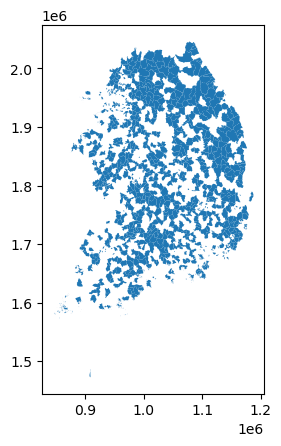

In [47]:
emd[(emd.EMD_CD).isin(tp)].plot()

<Axes: >

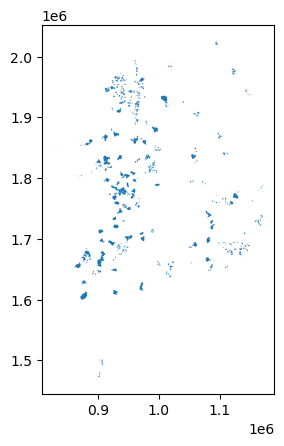

In [48]:
emd[(emd.EMD_CD).isin(tn)].plot()

<Axes: >

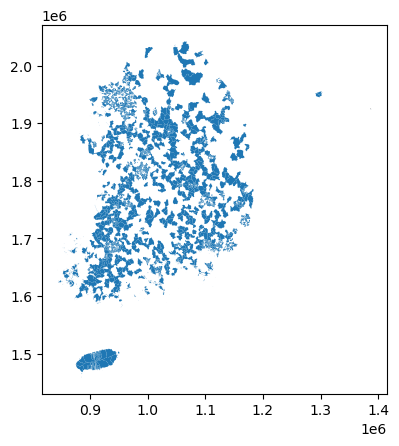

In [49]:
emd[(emd.EMD_CD).isin(fp)].plot()

<Axes: >

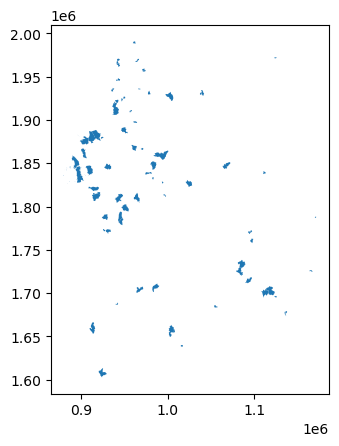

In [50]:
emd[(emd.EMD_CD).isin(fn)].plot()